In [2]:
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers

from keras.utils.vis_utils import plot_model

# Building and Preprocessing


In [3]:
builder = tfds.builder("imagenet_resized/32x32")
builder.download_and_prepare()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenet_resized/32x32/0.1.0.incompleteFKDJOC/imagenet_resized-train.tfrec…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenet_resized/32x32/0.1.0.incompleteFKDJOC/imagenet_resized-validation.…

Dataset imagenet_resized downloaded and prepared to /root/tensorflow_datasets/imagenet_resized/32x32/0.1.0. Subsequent calls will reuse this data.


In [4]:
INPUT_SHAPE = (32, 32, 3)
BATCH_SIZE = 128

In [5]:
train_data = tfds.load("imagenet_resized/32x32", split = "train[:50%]", as_supervised = True)
test_data  = tfds.load("imagenet_resized/32x32", split = "validation", as_supervised = True)

def preprocess(image, _):
    image = tf.cast(image, tf.float32) / 255.0
    return image, image

train_data = train_data.map(preprocess).batch(128)
test_data = test_data.map(preprocess).batch(128)

# Model Training

In [6]:
input_image = layers.Input(shape = INPUT_SHAPE)

x = layers.Conv2D(16, (3, 3), activation = "relu", padding = "same", kernel_initializer = "he_normal")(input_image)
x = layers.Conv2D(32, (3, 3), activation = "relu", padding = "same", kernel_initializer = "he_normal")(x)
x = layers.Conv2D(64, (3, 3), activation = "relu", padding = "same", kernel_initializer = "he_normal")(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation = "relu", padding = "same", kernel_initializer = "he_normal")(x)
x = layers.Conv2D(64, (3, 3), activation = "relu", padding = "same", kernel_initializer = "he_normal")(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation = "relu", padding = "same", kernel_initializer = "he_normal")(x)
x = layers.Conv2D(16, (3, 3), activation = "relu", padding = "same", kernel_initializer = "he_normal")(x)
encoder = layers.Conv2D(8, (3, 3), activation = "sigmoid", padding = "same")(x)

x = layers.Conv2D(16, (3, 3), activation = "relu", padding = "same", kernel_initializer = "he_normal")(encoder)
x = layers.Conv2D(32, (3, 3), activation = "relu", padding = "same", kernel_initializer = "he_normal")(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation = "relu", padding = "same", kernel_initializer = "he_normal")(x)
x = layers.Conv2D(128, (3, 3), activation = "relu", padding = "same", kernel_initializer = "he_normal")(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation = "relu", padding = "same", kernel_initializer = "he_normal")(x)
x = layers.Conv2D(32, (3, 3), activation = "relu", padding = "same", kernel_initializer = "he_normal")(x)
x = layers.Conv2D(16, (3, 3), activation = "relu", padding = "same", kernel_initializer = "he_normal")(x)
decoder = layers.Conv2D(3, (3, 3), activation = "sigmoid", padding = "same")(x)

autoencoder = keras.Model(input_image, decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       73856     
                                                             

In [7]:
epochs = 30
callback = keras.callbacks.EarlyStopping(monitor = "loss", patience = 5)

autoencoder.compile(optimizer = "adam", loss = "mean_squared_error", metrics = ["mean_squared_error"])

history = autoencoder.fit(train_data,
                    validation_data = test_data,
                    epochs = epochs,
                    callbacks = [callback])

Epoch 1/30
5005/5005 [==============================] - 256s 47ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 2/30
5005/5005 [==============================] - 239s 48ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 3/30
5005/5005 [==============================] - 237s 47ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 4/30
5005/5005 [==============================] - 240s 48ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 5/30
5005/5005 [==============================] - 238s 48ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 6/30
5005/5005 [==============================] - 237s 47ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0029 - val_mean_squared_error: 0.002

# Performance Graphics

In [23]:
def plot_history(history):
    plt.figure()
    plt.plot(history.epoch, history.history['val_loss'], 'o-r', label="Validation")
    plt.plot(history.epoch, history.history['loss'],',-y', label="Training")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend()

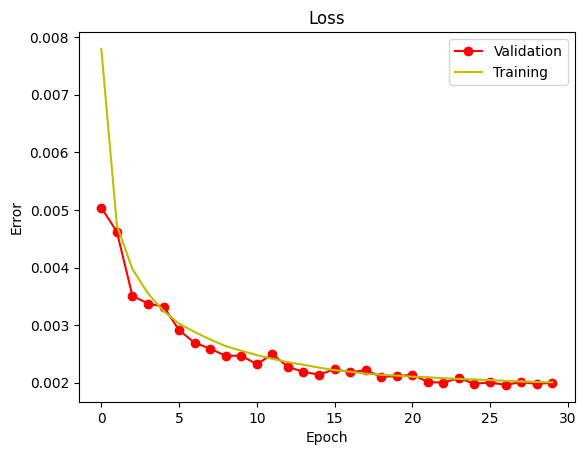

In [24]:
plot_history(history)

# Showcase

4/4 [==============================] - 1s 7ms/step


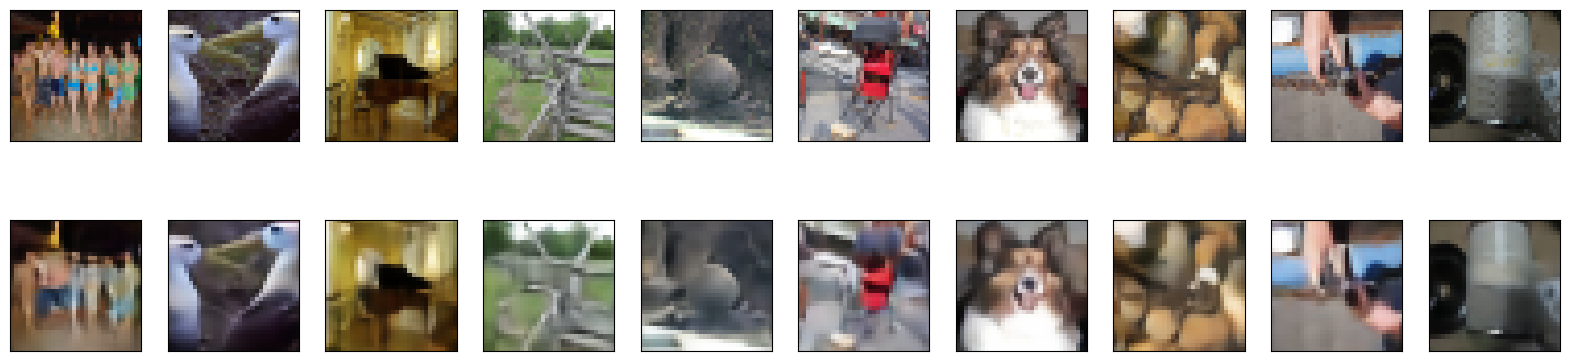

In [12]:
def display_single_subplot(img, n_row, n_col, cell_num):
	ax = plt.subplot(n_row, n_col, cell_num)
	plt.imshow(img)
	ax.get_xaxis().set_visible(False)
	ax.get_yaxis().set_visible(False)

n = 10
batch = np.random.randint(0, len(test_data))

while batch:
    image_batch, _ = next(iter(test_data))
    batch -= 1
predicted_batch = autoencoder.predict(image_batch)

display_indexes = np.random.choice(128, n, replace = False)

showcase_images = [image_batch[i] for i in display_indexes]
showcase_predicted = [predicted_batch[i] for i in display_indexes]

fig = plt.figure(figsize=(n*2, 5))
for i in range(n):
    display_single_subplot(showcase_images[i], n_row = 2, n_col = n, cell_num = i + 1)
    display_single_subplot(showcase_predicted[i], n_row = 2, n_col = n, cell_num = n + i + 1)
plt.show()